In [1]:
import numpy as np
import cPickle
import cv2
import glob
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from utils.template_match_target import *

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        X_id.append(int(flbase.split('lola_')[1].split('.png')[0]))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id_ = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    data = data.reshape(len(data),img_width,img_height,1)
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id_

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    
def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

In [17]:
dim, inv_color, rescale = 256, 1, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 1))
number of test files are: 240
('test shape:', (240, 256, 256, 1))


In [18]:
from keras.models import load_model

Using TensorFlow backend.


In [19]:
filename = 'models/unet_s256_rings_predfull_FL5_glorot_normal.h5'
model = load_model(filename)

In [20]:
n,off=2,0
target = model.predict(test_data[off:(n+off)].astype('float32'))
target_ids = test_id[off:(n+off)]

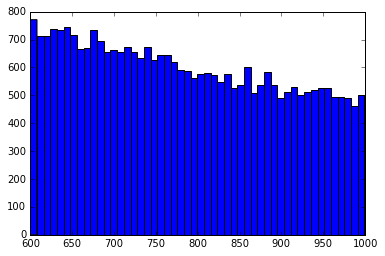

In [10]:
#convert pixel radius to absolute
P = cPickle.load(open('datasets/rings/Test_rings/lolaout_test.p', 'r'))
#P = cPickle.load(open('datasets/ilen_1500_to_2500/ilen_1500/outp_p0.p', 'r'))

#distribution of pix_to_km values.
arr = []
for i in range(len(P)):
    P_ = P[i]
    arr.append(P_['box'][2] - P_['box'][0])
    
plt.hist(arr,50);

# there's a problem here where the radii are all exactly the same!! Bug somewhere?

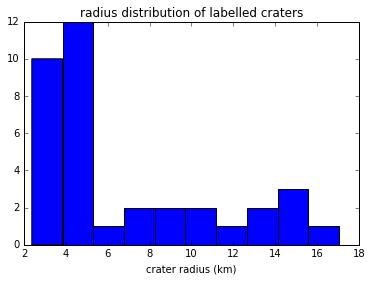

In [84]:
#code for checking that a discovered crater is new, and hasn't been already discovered in another image.
master_img_height_pix = 23040.0  #number of pixels for height
master_img_height_lat = 180.0
R_moon = 1737.4                  #radius of the moon (km)
olen = 256.0                     #output length (pixels)

match_thresh2 = 50.  #this may be too strong?
dim = 256
pred_crater_dist = np.empty([0,3])
for i in range(len(target)):
    coords = template_match_target(target[i])
    P_ = P[target_ids[i]]
    img_pix_height = float(P_['box'][2] - P_['box'][0])
    pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180.0)*(img_pix_height/olen)*r_moon
    long_pix,lat_pix,radii_pix = coords.T
    radii_km = radii_pix*pix_to_km
    long_deg = P_['llbd'][0] + (P_['llbd'][1]-P_['llbd'][0])*(long_pix/float(dim))
    lat_deg = P_['llbd'][3] - (P_['llbd'][3]-P_['llbd'][2])*(lat_pix/float(dim))
    tuple_ = np.column_stack((long_deg,lat_deg,radii_km))
    
    #only add unique (non-duplicate) values to the master pred_crater_dist
    if len(pred_crater_dist) > 0: 
        for j in range(len(tuple_)):
            diff = (pred_crater_dist - tuple_[j])**2
            diffsum = np.asarray([sum(x) for x in diff])
            index = diffsum < match_thresh2
            if len(np.where(index==True)[0]) == 0: #unique value
                pred_crater_dist = np.vstack((pred_crater_dist,tuple_[j]))
    else:
        pred_crater_dist = np.concatenate((pred_crater_dist,tuple_))

lat_, long_, rad = pred_crater_dist.T
plt.hist(rad, 10);
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')

In [25]:
#original
pred_crater_dist_old = []
for i in range(len(target)):
    coords = template_match_target(target[i])
    img_pix_height = float(P[target_ids[i]]['box'][2] - P[target_ids[i]]['box'][0])
    pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180.)*(img_pix_height/dim)*R_moon
    if len(coords) >= 1:
        _,_,radii = zip(*coords*pix_to_km)
        pred_crater_dist_old += list(radii)
        
plt.hist(pred_crater_dist_old, 10)

0
1


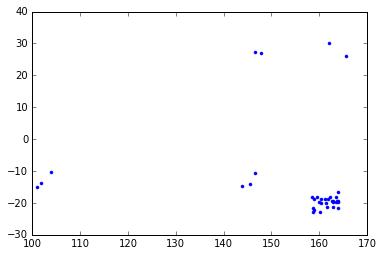

In [65]:
plt.plot(lat_,long_,'.')

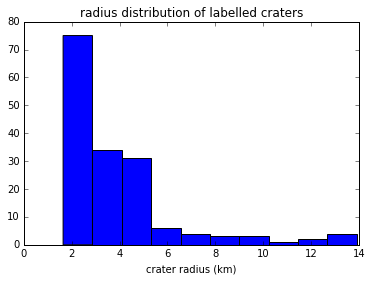

In [71]:
plt.hist(master_radii_dist, 10)
plt.title('radius distribution of labelled craters')
plt.xlabel('crater radius (km)')

# Compare csv diameter (km) to diameter (pix)

In [10]:
P = cPickle.load(open('datasets/rings/Test_rings/lolaout_test.p', 'r'))
csvs = glob.glob('datasets/rings/Test_rings/*.csv')

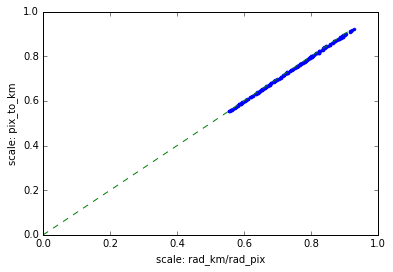

In [26]:
master_img_height_pix = 23040.0  #number of pixels for height
master_img_height_lat = 180.0
R_moon = 1737.4                  #radius of the moon (km)
olen = 256.0                     #output length (pixels)

scale_csv_direct = []
scale_pix_to_km = []
for csv in csvs:
    d = pd.read_csv(csv)
    P_ = P[int(os.path.basename(csv).split('lola_')[1].split('.csv')[0])]
    img_pix_height = float(P_['box'][2] - P_['box'][0])
    pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180.0)*(img_pix_height/olen)*R_moon
    rad_pix = d['Diameter (pix)'].values/2.
    rad_km = d['Diameter (km)'].values/2.
    
    ratio = rad_km/rad_pix
    scale_csv_direct.append(ratio[0])
    scale_pix_to_km.append(pix_to_km)
    if np.abs(np.max(ratio) - np.min(ratio)) > 1e-5:
        print "discrepancy in %s"%csv
    
# plt.hist(np.round(rad_pix)*pix_to_km, label='converted')
# plt.hist(rad_km, alpha=0.6, label='true')
# plt.legend()
#plt.hist(rad_km/rad_pix);
plt.plot(scale_csv_direct, scale_pix_to_km, '.')
plt.plot([0,max(scale_pix_to_km)],[0,max(scale_pix_to_km)], '--')
plt.ylabel('scale: pix_to_km')
plt.xlabel('scale: rad_km/rad_pix')
plt.savefig('output_dir/images/scale_ratio_test.png')

In [39]:
P_

{'box': [7644, 11968, 8619, 12943],
 'llbd': array([ 119.71875  ,  127.3359375,  -11.1171875,   -3.5      ])}

## Get unique_thresh2 estimate for crater_distribution_extract_new.py
I.e. an order of magnitude threshold should be such that the difference in $$(long_a - long_b)^2 + (lat_a - lat_b)^2 + (rad_a - rad_b)^2$$ for all entries in a csv file lead to unique values.

In [6]:
import glob
files = glob.glob('datasets/rings/Test_rings/*.csv')

In [3]:
csv.head()

,Diameter (km),Lat,Long,x,y,Diameter (pix)
0,12.299414,-10.737407,139.943674,151.353241,250.939001,15.300968
1,6.259036,-10.474197,138.968248,115.151231,241.006140,7.786494
2,8.107086,-10.415080,142.350568,240.724021,239.164887,10.085542
3,45.157000,-10.398437,138.195312,86.440179,238.197206,56.177133
4,14.313507,-10.325529,142.038801,229.187984,235.713168,17.806581


In [73]:
#since diameter is much larger range than long lat, need to standardize/normalize them. 
min_thresh2 = 50
std_lat, std_long, std_rad = [], [], []
range_lat, range_long, range_rad = [], [], []
for f in files[0:10]:
    csv = pd.read_csv(f)
    GT_radii = csv['Diameter (km)'].values/2
    GT_lat = csv['Lat'].values
    GT_long = csv['Long'].values
    tuple_ = np.column_stack((GT_long,GT_lat,GT_radii))
    
    std_lat.append(np.std(GT_lat)); std_long.append(np.std(GT_long)); std_rad.append(np.std(GT_radii));
    range_lat.append(np.max(GT_lat) - np.min(GT_lat)); 
    range_long.append(np.max(GT_long) - np.min(GT_long)); 
    range_rad.append(np.max(GT_radii) - np.min(GT_radii));
    
    for j in range(len(tuple_)):
        #diff = (tuple_ - tuple_[j])**2
        #diffsum = np.asarray([sum(x) for x in diff])
        long_, lat_, rad_ = tuple_.T
        diffsum = 25*(long_ - GT_long[j])**2 + 25*(lat_ - GT_lat[j])**2 + (rad_ - GT_radii[j])**2
        diffsum = np.delete(diffsum, j)
        min_thresh2 = np.min((min_thresh2,min(diffsum)))

print min_thresh2

0.157607011172


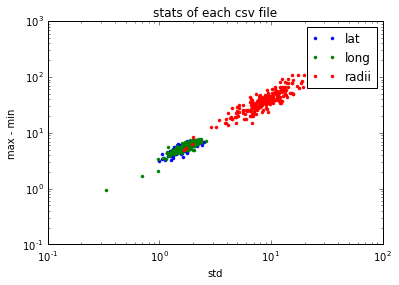

In [64]:
#radii has about ~5x higher standard deviation (25x more variance) in a given csv file.
#BUT, overall, long and lat have higher ranges/standard deviations... 
plt.plot(std_lat, range_lat, '.',label='lat')
plt.plot(std_long, range_long, '.',label='long')
plt.plot(std_rad, range_rad, '.',label='radii')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('max - min')
plt.xlabel('std')
plt.title('stats of each csv file')
plt.legend()

In [3]:
alanall = pd.read_csv('utils/alanalldata.csv')
alanall.head()

,Unnamed: 0,Unnamed: 0.1,Diameter (km),Long,Lat,tag
0,0,0,7.480187,103.648808,-58.915306,standard
1,1,1,6.787110,109.085532,-58.961397,standard
2,2,2,7.143313,113.439137,-59.791020,standard
3,3,3,13.778037,119.801506,-58.949874,standard
4,4,4,7.744244,120.419883,-58.803922,standard


In [4]:
std_r, std_lat, std_long = np.std(alanall['Diameter (km)']), np.std(alanall['Lat']), np.std(alanall['Long'])

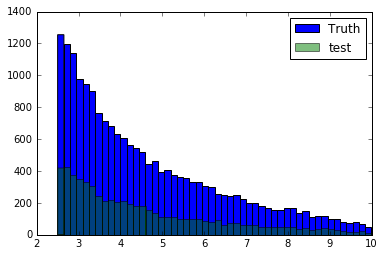

In [37]:
bins = 50
alanall = pd.read_csv('utils/alanalldata.csv')
truth = alanall['Diameter (km)']/2.
plt.hist(truth, bins, label='Truth');

data = np.load('datasets/rings/Test_rings/unique_GTcraters_ut20.005.npy')
long_,lat_,rad_ = data.T
rad_ = rad_[rad_ <= np.max(truth)]
plt.hist(rad_, bins, alpha=0.5, label='test');
plt.legend()

## Testing speed of algorithm - 2 seconds at slowest

In [50]:
dir = 'datasets/rings/Test_rings'

truth = np.load('%s/test_GTcraterdist_full.npy'%dir)
data = np.load('%s/test_predcraterdist_debug_n10000.npy'%dir)
#data = np.load('%s/test_predcraterdist_n30016.npy'%dir)

unique_thresh2=1e-6

In [48]:
%%time
i=0
data_cut = data[i:]                                         #compare only with higher indices, include entry i from data

diff = (data_cut - data_cut[0])**2
diffsum = np.asarray([sum(x) for x in diff])                #sum((lat-lat_i)^2 + (long-long_i)^2 + (rad-rad_i)^2)
index = diffsum < unique_thresh2
dup = np.where(index == True)[0]                            #get duplicates
if len(dup) > 1:                                            #will be at least 1 match for 0th slot
    data[i] = np.mean(data_cut[dup],axis=0)                 #take average of duplicate coords, store in *original* data array
    keep = np.where(index==False)[0]                        #indices of non-duplicate entries
    data = np.concatenate((data[0:i+1],data_cut[keep]))     #concatenate and remove duplicates

CPU times: user 904 ms, sys: 58.9 ms, total: 963 ms
Wall time: 1.01 s


Figuring out why the god damned algorithm takes so long

In [9]:
dir = 'datasets/rings/Test_rings'
pred = np.load('%s/test_modelpreds_n1000_new.npy'%dir)
id = np.load('%s/test_id.npy'%dir)
P = cPickle.load(open('%s/lolaout_test.p'%dir, 'r'))

(<matplotlib.image.AxesImage at 0x111b5af10>, 1000)

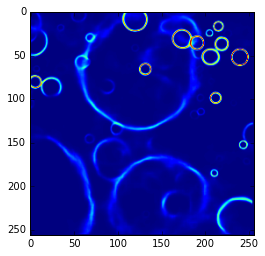

In [6]:
plt.imshow(pred[0]), len(pred)

In [ ]:
master_img_height_pix = 23040.  #number of pixels for height
master_img_height_lat = 180.    #degrees used for latitude
r_moon = 1737.4                 #radius of the moon (km)
dim = 256                       #image dimension (pixels, assume dim=height=width)
unique_thresh2 = 1

pred_crater_dist = np.empty([0,3])
for i in range(len(pred)):
    print i, len(pred_crater_dist)
    coords = template_match_target(pred[i])
    if len(coords) > 0:
        P_ = P[id[i]]
        img_pix_height = float(P_['box'][2] - P_['box'][0])
        pix_to_km = (master_img_height_lat/master_img_height_pix)*(np.pi/180.0)*(img_pix_height/float(dim))*r_moon
        long_pix,lat_pix,radii_pix = coords.T
        radii_km = radii_pix*pix_to_km
        long_deg = P_['llbd'][0] + (P_['llbd'][1]-P_['llbd'][0])*(long_pix/float(dim))
        lat_deg = P_['llbd'][3] - (P_['llbd'][3]-P_['llbd'][2])*(lat_pix/float(dim))
        tuple_ = np.column_stack((long_deg,lat_deg,radii_km))

        #only add unique (non-duplicate) values to the master pred_crater_dist
        if len(pred_crater_dist) > 0:
            for j in range(len(tuple_)):
                diff = (pred_crater_dist - tuple_[j])**2
                diffsum = np.asarray([sum(x) for x in diff])
                index = diffsum < unique_thresh2
                if len(np.where(index==True)[0]) == 0: #unique value
                    pred_crater_dist = np.vstack((pred_crater_dist,tuple_[j]))
        else:
            pred_crater_dist = np.concatenate((pred_crater_dist,tuple_))
            
np.save('%s/test_modeldist_n1000_new.npy'%dir,pred_crater_dist)

0 0
1 19
2 34
3 51
4 58
5 79
6 82
7 104
8 122
9 134
10 172
11 194
12 218
13 244
14 247
15 281
16 302
17 340
18 369
19 383
20 395
21 433
22 462
23 480
24 522
25 545
26 549
27 579
28 591
29 616
30 637
31 642
32 681
33 705
34 723
35 747
36 758
37 779
38 805
39 818
40 863
41 880
42 892
43 900
44 912
45 929
46 942
47 961
48 972
49 999
50 1015
51 1034
52 1036
53 1050
54 1077
55 1099
56 1135
57 1155
58 1174
59 1185
60 1207
61 1247
62 1253
63 1293
64 1304
65 1308
66 1332
67 1359
68 1367
69 1369
70 1374
71 1377
72 1394
73 1421
74 1449
75 1453
76 1479
77 1504
78 1519
79 1528
80 1534
81 1538
82 1556
83 1560
84 1568
85 1600
86 1625
87 1630
88 1656
89 1659
90 1677
91 1711
92 1739
93 1777
94 1798
95 1821
96 1843
97 1869
98 1881
99 1938
100 1965
101 1986
102 1990
103 2007
104 2018
105 2034
106 2040
107 2042
108 2044
109 2046
110 2077
111 2098
112 2116
113 2121
114 2141
115 2158
116 2170
117 2194
118 2218
119 2229
120 2247
121 2256
122 2264
123 2289
124 2310
125 2340
126 2360
127 2386
128 2399
129 240